# Imports

## Packages

In [63]:
import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import holidays
warnings.filterwarnings('ignore')

In [64]:
from helper import *

## Data

In [65]:
df = pd.read_csv('../data/merged/merged.csv', parse_dates= ['Timestamp'])
df.head()

,Timestamp,DE_AT_LU,DE_LU,DK_1,SE_4,DE_AT_LU_Exports_Volume,DE_LU_Exports_Volume,DK_1_Exports_Volume,SE_4_Exports_Volume,Day_Ahead_Prices,Forecasted Load,Actual Load,Solar,Wind Offshore,Wind Onshore,TTF=F_Price,CFI2Z3_Price,CO2_prices_Price,Biomass - Actual Aggregated [MW],Waste - Actual Aggregated [MW]
0,2017-12-24 00:00:00,555.0,0.0,259.0,0.0,0.0,NaN,0.0,535.0,-40.84,1303.0,1302.0,0.0,201.0,498.0,NaN,NaN,NaN,NaN,NaN
1,2017-12-24 01:00:00,599.0,0.0,390.0,0.0,0.0,NaN,0.0,750.0,-43.18,1236.0,1252.0,0.0,204.0,506.0,NaN,NaN,NaN,NaN,NaN
2,2017-12-24 02:00:00,600.0,0.0,445.0,0.0,0.0,NaN,0.0,831.0,-50.04,1204.0,1230.0,0.0,203.0,511.0,NaN,NaN,NaN,NaN,NaN
3,2017-12-24 03:00:00,600.0,0.0,250.0,0.0,0.0,NaN,0.0,650.0,-42.31,1195.0,1194.0,0.0,202.0,513.0,NaN,NaN,NaN,NaN,NaN
4,2017-12-24 04:00:00,600.0,0.0,68.0,0.0,0.0,NaN,0.0,457.0,-40.09,1189.0,1179.0,0.0,202.0,497.0,NaN,NaN,NaN,NaN,NaN


# Pre-processing

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


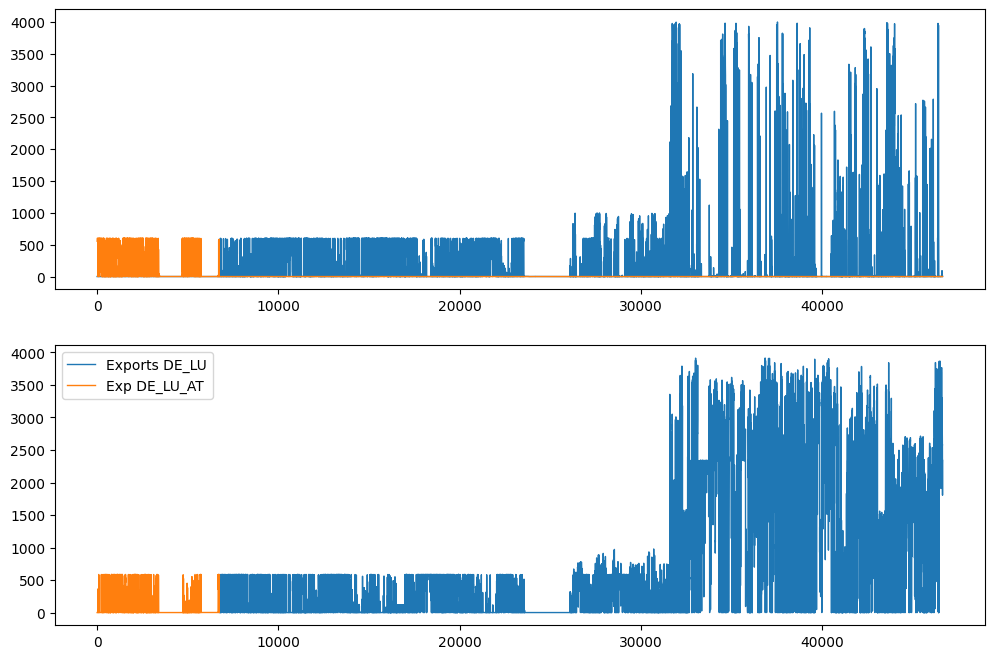

In [66]:
fig,axes = plt.subplots(2,1 ,figsize=(12,8))
axes[0].plot(df['DE_LU'], linewidth = 1, label = 'Imports DE_LU')
axes[0].plot(df['DE_AT_LU'], linewidth = 1, label = 'Imports DE_LU_AT')
plt.legend()
axes[1].plot(df['DE_LU_Exports_Volume'], linewidth = 1, label = 'Exports DE_LU')
axes[1].plot(df['DE_AT_LU_Exports_Volume'], linewidth = 1, label = 'Exp DE_LU_AT')
plt.legend()

In [67]:
df[(df['DE_AT_LU'].isna()) & (df['DE_LU'].isna())]

,Timestamp,DE_AT_LU,DE_LU,DK_1,SE_4,DE_AT_LU_Exports_Volume,DE_LU_Exports_Volume,DK_1_Exports_Volume,SE_4_Exports_Volume,Day_Ahead_Prices,Forecasted Load,Actual Load,Solar,Wind Offshore,Wind Onshore,TTF=F_Price,CFI2Z3_Price,CO2_prices_Price,Biomass - Actual Aggregated [MW],Waste - Actual Aggregated [MW]
46660,2023-04-20 23:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-,-
46661,2023-04-21 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-,-
46662,2023-04-21 01:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-,-
46663,2023-04-21 02:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-,-
46664,2023-04-21 03:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-,-
46665,2023-04-21 04:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-,-
46666,2023-04-21 05:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-,-
46667,2023-04-21 06:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-,-
46668,2023-04-21 07:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-,-
46669,2023-04-21 08:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-,-


In [68]:
df[(df['DE_LU_Exports_Volume'].isna()) & (df['DE_AT_LU_Exports_Volume'].isna())]

,Timestamp,DE_AT_LU,DE_LU,DK_1,SE_4,DE_AT_LU_Exports_Volume,DE_LU_Exports_Volume,DK_1_Exports_Volume,SE_4_Exports_Volume,Day_Ahead_Prices,Forecasted Load,Actual Load,Solar,Wind Offshore,Wind Onshore,TTF=F_Price,CFI2Z3_Price,CO2_prices_Price,Biomass - Actual Aggregated [MW],Waste - Actual Aggregated [MW]
46636,2023-04-19 23:00:00,0.0,0.0,0.0,676.0,NaN,NaN,NaN,NaN,39.48,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-,-
46637,2023-04-20 00:00:00,0.0,0.0,0.0,717.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-,-
46638,2023-04-20 01:00:00,0.0,0.0,0.0,430.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-,-
46639,2023-04-20 02:00:00,0.0,0.0,0.0,499.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-,-
46640,2023-04-20 03:00:00,0.0,0.0,0.0,683.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-,-
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46701,2023-04-22 16:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-,-
46702,2023-04-22 17:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-,-
46703,2023-04-22 18:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-,-
46704,2023-04-22 19:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-,-


In [69]:
cols_na = ['DE_LU_Exports_Volume', 'DE_AT_LU_Exports_Volume', 'DE_AT_LU', 'DE_LU']
for col in cols_na:
    df[col].fillna(0, inplace = True)

df['DE_LU_corr'] = df['DE_AT_LU'] + df['DE_LU']
df.drop(['DE_AT_LU', 'DE_LU'], axis = 1, inplace = True)

df['DE_LU_Exports_Volume_corr'] = df['DE_LU_Exports_Volume'] + df['DE_AT_LU_Exports_Volume']
df.drop(['DE_LU_Exports_Volume', 'DE_AT_LU_Exports_Volume'], axis = 1, inplace = True)

In [70]:
df.isna().sum()

Timestamp                                0
DK_1                                    46
SE_4                                    46
DK_1_Exports_Volume                     70
SE_4_Exports_Volume                     70
Day_Ahead_Prices                        69
Forecasted Load                         70
Actual Load                             70
Solar                                   70
Wind Offshore                           70
Wind Onshore                            70
TTF=F_Price                          45372
CFI2Z3_Price                         45343
CO2_prices_Price                     45419
Biomass  - Actual Aggregated [MW]      201
Waste  - Actual Aggregated [MW]        201
DE_LU_corr                               0
DE_LU_Exports_Volume_corr                0
dtype: int64

In [71]:
df[df['CO2_prices_Price'].isna()]

,Timestamp,DK_1,SE_4,DK_1_Exports_Volume,SE_4_Exports_Volume,Day_Ahead_Prices,Forecasted Load,Actual Load,Solar,Wind Offshore,Wind Onshore,TTF=F_Price,CFI2Z3_Price,CO2_prices_Price,Biomass - Actual Aggregated [MW],Waste - Actual Aggregated [MW],DE_LU_corr,DE_LU_Exports_Volume_corr
0,2017-12-24 00:00:00,259.0,0.0,0.0,535.0,-40.84,1303.0,1302.0,0.0,201.0,498.0,NaN,NaN,NaN,NaN,NaN,555.0,0.0
1,2017-12-24 01:00:00,390.0,0.0,0.0,750.0,-43.18,1236.0,1252.0,0.0,204.0,506.0,NaN,NaN,NaN,NaN,NaN,599.0,0.0
2,2017-12-24 02:00:00,445.0,0.0,0.0,831.0,-50.04,1204.0,1230.0,0.0,203.0,511.0,NaN,NaN,NaN,NaN,NaN,600.0,0.0
3,2017-12-24 03:00:00,250.0,0.0,0.0,650.0,-42.31,1195.0,1194.0,0.0,202.0,513.0,NaN,NaN,NaN,NaN,NaN,600.0,0.0
4,2017-12-24 04:00:00,68.0,0.0,0.0,457.0,-40.09,1189.0,1179.0,0.0,202.0,497.0,NaN,NaN,NaN,NaN,NaN,600.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46701,2023-04-22 16:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-,-,0.0,0.0
46702,2023-04-22 17:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-,-,0.0,0.0
46703,2023-04-22 18:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-,-,0.0,0.0
46704,2023-04-22 19:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-,-,0.0,0.0


In [72]:
df = get_dt_info(df, 'Timestamp', yr = True, qt = True, mo = True, date = True, day = True, wd = True, h = True)
df = get_dt_info(df, 'Date', w = True)
df.tail().T

,46701,46702,46703,46704,46705
Timestamp,2023-04-22 16:00:00,2023-04-22 17:00:00,2023-04-22 18:00:00,2023-04-22 19:00:00,2023-04-22 20:00:00
DK_1,NaN,NaN,NaN,NaN,NaN
SE_4,NaN,NaN,NaN,NaN,NaN
DK_1_Exports_Volume,NaN,NaN,NaN,NaN,NaN
SE_4_Exports_Volume,NaN,NaN,NaN,NaN,NaN
Day_Ahead_Prices,NaN,NaN,NaN,NaN,NaN
Forecasted Load,NaN,NaN,NaN,NaN,NaN
Actual Load,NaN,NaN,NaN,NaN,NaN
Solar,NaN,NaN,NaN,NaN,NaN
Wind Offshore,NaN,NaN,NaN,NaN,NaN


## Differentiate business and non-business days

In [73]:
# calendar of holidays in DK
dk_bus = pd.tseries.offsets.CustomBusinessDay(calendar = holidays.DK(years = [2018, 2023]))

# range of business days, excluding weekends and holidays
dk_bus_days = pd.bdate_range(min(df['Date']), max(df['Date']), freq = dk_bus)
df['business'] = df['Date'].isin(dk_bus_days)

In [74]:
df.tail().T

,46701,46702,46703,46704,46705
Timestamp,2023-04-22 16:00:00,2023-04-22 17:00:00,2023-04-22 18:00:00,2023-04-22 19:00:00,2023-04-22 20:00:00
DK_1,NaN,NaN,NaN,NaN,NaN
SE_4,NaN,NaN,NaN,NaN,NaN
DK_1_Exports_Volume,NaN,NaN,NaN,NaN,NaN
SE_4_Exports_Volume,NaN,NaN,NaN,NaN,NaN
Day_Ahead_Prices,NaN,NaN,NaN,NaN,NaN
Forecasted Load,NaN,NaN,NaN,NaN,NaN
Actual Load,NaN,NaN,NaN,NaN,NaN
Solar,NaN,NaN,NaN,NaN,NaN
Wind Offshore,NaN,NaN,NaN,NaN,NaN


# Imputation

In [75]:
for column in ['Biomass  - Actual Aggregated [MW]', 'Waste  - Actual Aggregated [MW]']:
    df[column] = df[column].apply(lambda row: np.nan if row == '-' else row)

In [76]:
# check for NaN values
for col in df.columns:
    a = df[col].isna().sum()
    if a > 0:
        b = df[(df[col].isna()) & (df['business'] == True)]
        print(col, a, 'of which', len(b), 'in', len(b['Date'].unique()),'business days')

DK_1 46 of which 25 in 2 business days
SE_4 46 of which 25 in 2 business days
DK_1_Exports_Volume 70 of which 49 in 3 business days
SE_4_Exports_Volume 70 of which 49 in 3 business days
Day_Ahead_Prices 69 of which 48 in 2 business days
Forecasted Load 70 of which 49 in 3 business days
Actual Load 70 of which 49 in 3 business days
Solar 70 of which 49 in 3 business days
Wind Offshore 70 of which 49 in 3 business days
Wind Onshore 70 of which 49 in 3 business days
TTF=F_Price 45372 of which 32026 in 1390 business days
CFI2Z3_Price 45343 of which 31997 in 1390 business days
CO2_prices_Price 45419 of which 32073 in 1390 business days
Biomass  - Actual Aggregated [MW] 369 of which 243 in 13 business days
Waste  - Actual Aggregated [MW] 369 of which 243 in 13 business days


In [77]:
# in most cases, 'TTF', 'CO2' and 'coal' NaN are in non-business days, where the price is the same as the last business day --> ffill
for col in ['TTF=F_Price', 'CO2_prices_Price','CFI2Z3_Price']:
    df[col].fillna(method = 'ffill', inplace = True)

In [78]:
# check for NaN values
for col in df.columns:
    a = df[col].isna().sum()
    if a > 0:
        b = df[(df[col].isna()) & (df['business'])]
        print(col, a, 'of which', len(b), 'in', len(b['Date'].unique()),'business days')

DK_1 46 of which 25 in 2 business days
SE_4 46 of which 25 in 2 business days
DK_1_Exports_Volume 70 of which 49 in 3 business days
SE_4_Exports_Volume 70 of which 49 in 3 business days
Day_Ahead_Prices 69 of which 48 in 2 business days
Forecasted Load 70 of which 49 in 3 business days
Actual Load 70 of which 49 in 3 business days
Solar 70 of which 49 in 3 business days
Wind Offshore 70 of which 49 in 3 business days
Wind Onshore 70 of which 49 in 3 business days
TTF=F_Price 216 of which 144 in 6 business days
CFI2Z3_Price 120 of which 96 in 4 business days
CO2_prices_Price 216 of which 144 in 6 business days
Biomass  - Actual Aggregated [MW] 369 of which 243 in 13 business days
Waste  - Actual Aggregated [MW] 369 of which 243 in 13 business days


In [79]:
df.isna().sum()

Timestamp                              0
DK_1                                  46
SE_4                                  46
DK_1_Exports_Volume                   70
SE_4_Exports_Volume                   70
Day_Ahead_Prices                      69
Forecasted Load                       70
Actual Load                           70
Solar                                 70
Wind Offshore                         70
Wind Onshore                          70
TTF=F_Price                          216
CFI2Z3_Price                         120
CO2_prices_Price                     216
Biomass  - Actual Aggregated [MW]    369
Waste  - Actual Aggregated [MW]      369
DE_LU_corr                             0
DE_LU_Exports_Volume_corr              0
Year                                   0
Quarter                                0
Month                                  0
Date                                   0
Day                                    0
Weekday                                0
Hour            

In [80]:
idx_drop = []
# idx2 = []
for col in ['TTF=F_Price', 'CO2_prices_Price','CFI2Z3_Price']:
    idx = df[df[col].isna()]['Date'].unique()
    idx_drop.append(idx)
    print(col, idx)
    # idx_drop.append(df[df[col].isna()]['Date'].unique()[0])

idx_drop = [item for sublist in idx_drop for item in sublist]
# idx_drop = set(idx_drop)

TTF=F_Price <DatetimeArray>
['2017-12-24 00:00:00', '2017-12-25 00:00:00', '2017-12-26 00:00:00',
 '2017-12-27 00:00:00', '2017-12-28 00:00:00', '2017-12-29 00:00:00',
 '2017-12-30 00:00:00', '2017-12-31 00:00:00', '2018-01-01 00:00:00']
Length: 9, dtype: datetime64[ns]
CO2_prices_Price <DatetimeArray>
['2017-12-24 00:00:00', '2017-12-25 00:00:00', '2017-12-26 00:00:00',
 '2017-12-27 00:00:00', '2017-12-28 00:00:00', '2017-12-29 00:00:00',
 '2017-12-30 00:00:00', '2017-12-31 00:00:00', '2018-01-01 00:00:00']
Length: 9, dtype: datetime64[ns]
CFI2Z3_Price <DatetimeArray>
['2017-12-24 00:00:00', '2017-12-25 00:00:00', '2017-12-26 00:00:00',
 '2017-12-27 00:00:00', '2017-12-28 00:00:00']
Length: 5, dtype: datetime64[ns]


In [81]:
# these NaNs are at the beginning of the df and consecutive days
# we drop all the rows for those days, for the sake of completeness
df.drop(df[df['Date'].isin(idx_drop)].index, inplace = True)

In [82]:
df.head().T

,216,217,218,219,220
Timestamp,2018-01-02 00:00:00,2018-01-02 01:00:00,2018-01-02 02:00:00,2018-01-02 03:00:00,2018-01-02 04:00:00
DK_1,383.0,589.0,557.0,487.0,580.0
SE_4,0.0,0.0,0.0,0.0,0.0
DK_1_Exports_Volume,0.0,0.0,0.0,0.0,0.0
SE_4_Exports_Volume,808.0,1019.0,926.0,784.0,756.0
Day_Ahead_Prices,18.12,14.99,17.79,24.51,17.82
Forecasted Load,1258.0,1188.0,1167.0,1187.0,1235.0
Actual Load,1245.0,1203.0,1178.0,1180.0,1247.0
Solar,0.0,0.0,0.0,0.0,0.0
Wind Offshore,231.0,181.0,134.0,73.0,44.0


In [83]:
# check for NaN values
cols_na = []
for col in df.columns:
    a = df[col].isna().sum()
    if a > 0:
        cols_na.append(col)
        b = df[df[col].isna()]['Date'].unique()
        print(col, a, '\nbusiness days', len(b), b)

DK_1 46 
business days 3 <DatetimeArray>
['2023-04-20 00:00:00', '2023-04-21 00:00:00', '2023-04-22 00:00:00']
Length: 3, dtype: datetime64[ns]
SE_4 46 
business days 3 <DatetimeArray>
['2023-04-20 00:00:00', '2023-04-21 00:00:00', '2023-04-22 00:00:00']
Length: 3, dtype: datetime64[ns]
DK_1_Exports_Volume 70 
business days 4 <DatetimeArray>
['2023-04-19 00:00:00', '2023-04-20 00:00:00', '2023-04-21 00:00:00',
 '2023-04-22 00:00:00']
Length: 4, dtype: datetime64[ns]
SE_4_Exports_Volume 70 
business days 4 <DatetimeArray>
['2023-04-19 00:00:00', '2023-04-20 00:00:00', '2023-04-21 00:00:00',
 '2023-04-22 00:00:00']
Length: 4, dtype: datetime64[ns]
Day_Ahead_Prices 69 
business days 3 <DatetimeArray>
['2023-04-20 00:00:00', '2023-04-21 00:00:00', '2023-04-22 00:00:00']
Length: 3, dtype: datetime64[ns]
Forecasted Load 70 
business days 4 <DatetimeArray>
['2023-04-19 00:00:00', '2023-04-20 00:00:00', '2023-04-21 00:00:00',
 '2023-04-22 00:00:00']
Length: 4, dtype: datetime64[ns]
Actual Load

In [84]:
df.drop(df[df['Date'] == max(df['Date'])].index, inplace = True)

In [85]:
# check for NaN values
cols_na = []
for col in df.columns:
    a = df[col].isna().sum()
    if a > 0:
        cols_na.append(col)
        b = df[df[col].isna()]['Date'].unique()
        print(col, a, '\nbusiness days', len(b), b)

DK_1 25 
business days 2 <DatetimeArray>
['2023-04-20 00:00:00', '2023-04-21 00:00:00']
Length: 2, dtype: datetime64[ns]
SE_4 25 
business days 2 <DatetimeArray>
['2023-04-20 00:00:00', '2023-04-21 00:00:00']
Length: 2, dtype: datetime64[ns]
DK_1_Exports_Volume 49 
business days 3 <DatetimeArray>
['2023-04-19 00:00:00', '2023-04-20 00:00:00', '2023-04-21 00:00:00']
Length: 3, dtype: datetime64[ns]
SE_4_Exports_Volume 49 
business days 3 <DatetimeArray>
['2023-04-19 00:00:00', '2023-04-20 00:00:00', '2023-04-21 00:00:00']
Length: 3, dtype: datetime64[ns]
Day_Ahead_Prices 48 
business days 2 <DatetimeArray>
['2023-04-20 00:00:00', '2023-04-21 00:00:00']
Length: 2, dtype: datetime64[ns]
Forecasted Load 49 
business days 3 <DatetimeArray>
['2023-04-19 00:00:00', '2023-04-20 00:00:00', '2023-04-21 00:00:00']
Length: 3, dtype: datetime64[ns]
Actual Load 49 
business days 3 <DatetimeArray>
['2023-04-19 00:00:00', '2023-04-20 00:00:00', '2023-04-21 00:00:00']
Length: 3, dtype: datetime64[ns]
S

In [86]:
df_temp = df.copy()
# df_temp[(df_temp['Hour'] == 17) & ('2020-09-03'< df_temp['Date']) & (df_temp['Date'] <'2020-09-15')]

df_temp.isna().sum()

Timestamp                              0
DK_1                                  25
SE_4                                  25
DK_1_Exports_Volume                   49
SE_4_Exports_Volume                   49
Day_Ahead_Prices                      48
Forecasted Load                       49
Actual Load                           49
Solar                                 49
Wind Offshore                         49
Wind Onshore                          49
TTF=F_Price                            0
CFI2Z3_Price                           0
CO2_prices_Price                       0
Biomass  - Actual Aggregated [MW]    156
Waste  - Actual Aggregated [MW]      156
DE_LU_corr                             0
DE_LU_Exports_Volume_corr              0
Year                                   0
Quarter                                0
Month                                  0
Date                                   0
Day                                    0
Weekday                                0
Hour            

In [87]:
df_temp.shape

(46469, 27)

In [88]:
df_temp[df_temp['Waste  - Actual Aggregated [MW]']=='-']

,Timestamp,DK_1,SE_4,DK_1_Exports_Volume,SE_4_Exports_Volume,Day_Ahead_Prices,Forecasted Load,Actual Load,Solar,Wind Offshore,...,DE_LU_Exports_Volume_corr,Year,Quarter,Month,Date,Day,Weekday,Hour,Week,business


In [89]:
df_temp.dropna(axis=0, how='any', inplace=True)

In [90]:
df_temp.shape

(46313, 27)

In [91]:
df_temp.tail()

,Timestamp,DK_1,SE_4,DK_1_Exports_Volume,SE_4_Exports_Volume,Day_Ahead_Prices,Forecasted Load,Actual Load,Solar,Wind Offshore,...,DE_LU_Exports_Volume_corr,Year,Quarter,Month,Date,Day,Weekday,Hour,Week,business
46533,2023-04-15 16:00:00,0.0,991.0,600.0,0.0,45.79,1560.0,1557.0,169.0,836.0,...,2641.0,2023,2,4,2023-04-15,15,5,16,15,False
46534,2023-04-15 17:00:00,0.0,1098.0,600.0,0.0,51.78,1612.0,1593.0,87.0,831.0,...,2634.0,2023,2,4,2023-04-15,15,5,17,15,False
46535,2023-04-15 18:00:00,0.0,1090.0,600.0,0.0,54.53,1538.0,1534.0,21.0,818.0,...,2628.0,2023,2,4,2023-04-15,15,5,18,15,False
46536,2023-04-15 19:00:00,0.0,1119.0,600.0,0.0,52.31,1475.0,1482.0,1.0,788.0,...,2628.0,2023,2,4,2023-04-15,15,5,19,15,False
46537,2023-04-15 20:00:00,0.0,1116.0,600.0,0.0,50.01,1438.0,1438.0,0.0,787.0,...,2631.0,2023,2,4,2023-04-15,15,5,20,15,False


In [92]:
# for i in range(24):
#     check = df_temp[df_temp['Hour'] == i][cols_na].rolling(30, min_periods = 1, closed = 'left', axis = 'rows').mean()
#     df_temp[cols_na].fillna(value = check, inplace = True)
#     check = df_temp[df_temp['Hour'] == i][cols_na].rolling(24, min_periods = 1, closed = 'left', axis = 'rows').mean()
#     df_temp[cols_na].fillna(value = check, inplace = True)
#     check = df_temp[df_temp['Hour'] == i][cols_na].rolling(24, min_periods = 1, closed = 'left', axis = 'rows').mean()
#     df_temp[cols_na].fillna(value = check, inplace = True)

In [93]:
df_temp.info()

<class 'pandas.core.frame.DataFrame'>
Index: 46313 entries, 216 to 46537
Data columns (total 27 columns):
 #   Column                             Non-Null Count  Dtype         
---  ------                             --------------  -----         
 0   Timestamp                          46313 non-null  datetime64[ns]
 1   DK_1                               46313 non-null  float64       
 2   SE_4                               46313 non-null  float64       
 3   DK_1_Exports_Volume                46313 non-null  float64       
 4   SE_4_Exports_Volume                46313 non-null  float64       
 5   Day_Ahead_Prices                   46313 non-null  float64       
 6   Forecasted Load                    46313 non-null  float64       
 7   Actual Load                        46313 non-null  float64       
 8   Solar                              46313 non-null  float64       
 9   Wind Offshore                      46313 non-null  float64       
 10  Wind Onshore                       46

In [94]:
d = dict(tuple(df_temp.groupby('Hour')))
df_temp=pd.DataFrame(data=None)
    #split in 24 timestamps/hours
for i in range(24):
    for j in cols_na:
        d[i][j]=d[i][j].fillna(d[i][j].rolling(7,min_periods=1).mean().round(1))
        d[i][j]=d[i][j].fillna(d[i][j].rolling(14,min_periods=1).mean().round(1))
        d[i][j]=d[i][j].fillna(method='pad')
    if i==0:
        df_temp=d[i]
    else:
        df_temp=pd.concat([df_temp,d[i]])
df_temp=df_temp.sort_values('Timestamp')
df_temp.isna().sum()

Timestamp                            0
DK_1                                 0
SE_4                                 0
DK_1_Exports_Volume                  0
SE_4_Exports_Volume                  0
Day_Ahead_Prices                     0
Forecasted Load                      0
Actual Load                          0
Solar                                0
Wind Offshore                        0
Wind Onshore                         0
TTF=F_Price                          0
CFI2Z3_Price                         0
CO2_prices_Price                     0
Biomass  - Actual Aggregated [MW]    0
Waste  - Actual Aggregated [MW]      0
DE_LU_corr                           0
DE_LU_Exports_Volume_corr            0
Year                                 0
Quarter                              0
Month                                0
Date                                 0
Day                                  0
Weekday                              0
Hour                                 0
Week                     

In [95]:
cols_na

['DK_1',
 'SE_4',
 'DK_1_Exports_Volume',
 'SE_4_Exports_Volume',
 'Day_Ahead_Prices',
 'Forecasted Load',
 'Actual Load',
 'Solar',
 'Wind Offshore',
 'Wind Onshore',
 'Biomass  - Actual Aggregated [MW]',
 'Waste  - Actual Aggregated [MW]']

In [96]:
# check for NaN values
for col in df_temp.columns:
    a = df_temp[col].isna().sum()
    if a > 0:
        b = df_temp[df_temp[col].isna()]['Date'].unique()
        print(col, a, '\nbusiness days', len(b), b)

In [97]:
df_temp['Wind Total'] = df_temp['Wind Offshore'] + df_temp['Wind Onshore']
df_temp.drop(['Wind Offshore', 'Wind Onshore'], axis = 1, inplace = True)

In [98]:
old = list(df.columns)
new = list(['Timestamp','DK_1_imports','SE_4_imports','DK_1_exports','SE_4_exports','Day_Ahead_price','Forecasted_Load','Actual_Load', \
     'Solar_[MW]', 'Wind_Offshore_[MW]', 'Wind_Onshore_[MW]', 'ttf_price', 'coal_price', 'co2_price', 'Biomass_Actual_Aggregated_[MW]', \
      'Waste_Actual_Aggregated_[MW]', 'DE_LU_AT_imports','DE_LU_AT_exports', 'Year', 'Quarter', \
      'Month', 'Date', 'Day', 'Weekday', 'Hour', 'Week', 'business'])

In [99]:
dict(zip(old,new))

{'Timestamp': 'Timestamp',
 'DK_1': 'DK_1_imports',
 'SE_4': 'SE_4_imports',
 'DK_1_Exports_Volume': 'DK_1_exports',
 'SE_4_Exports_Volume': 'SE_4_exports',
 'Day_Ahead_Prices': 'Day_Ahead_price',
 'Forecasted Load': 'Forecasted_Load',
 'Actual Load': 'Actual_Load',
 'Solar': 'Solar_[MW]',
 'Wind Offshore': 'Wind_Offshore_[MW]',
 'Wind Onshore': 'Wind_Onshore_[MW]',
 'TTF=F_Price': 'ttf_price',
 'CFI2Z3_Price': 'coal_price',
 'CO2_prices_Price': 'co2_price',
 'Biomass  - Actual Aggregated [MW]': 'Biomass_Actual_Aggregated_[MW]',
 'Waste  - Actual Aggregated [MW]': 'Waste_Actual_Aggregated_[MW]',
 'DE_LU_corr': 'DE_LU_AT_imports',
 'DE_LU_Exports_Volume_corr': 'DE_LU_AT_exports',
 'Year': 'Year',
 'Quarter': 'Quarter',
 'Month': 'Month',
 'Date': 'Date',
 'Day': 'Day',
 'Weekday': 'Weekday',
 'Hour': 'Hour',
 'Week': 'Week',
 'business': 'business'}

In [100]:
df_temp.rename(columns = dict(zip(old,new)), inplace=True)

In [101]:
df_temp.head()

,Timestamp,DK_1_imports,SE_4_imports,DK_1_exports,SE_4_exports,Day_Ahead_price,Forecasted_Load,Actual_Load,Solar_[MW],ttf_price,...,Year,Quarter,Month,Date,Day,Weekday,Hour,Week,business,Wind Total
216,2018-01-02 00:00:00,383.0,0.0,0.0,808.0,18.12,1258.0,1245.0,0.0,19.32,...,2018,1,1,2018-01-02,2,1,0,1,True,429.0
217,2018-01-02 01:00:00,589.0,0.0,0.0,1019.0,14.99,1188.0,1203.0,0.0,19.32,...,2018,1,1,2018-01-02,2,1,1,1,True,375.0
218,2018-01-02 02:00:00,557.0,0.0,0.0,926.0,17.79,1167.0,1178.0,0.0,19.32,...,2018,1,1,2018-01-02,2,1,2,1,True,313.0
219,2018-01-02 03:00:00,487.0,0.0,0.0,784.0,24.51,1187.0,1180.0,0.0,19.32,...,2018,1,1,2018-01-02,2,1,3,1,True,229.0
220,2018-01-02 04:00:00,580.0,0.0,0.0,756.0,17.82,1235.0,1247.0,0.0,19.32,...,2018,1,1,2018-01-02,2,1,4,1,True,175.0


In [102]:
df_temp.columns

Index(['Timestamp', 'DK_1_imports', 'SE_4_imports', 'DK_1_exports',
       'SE_4_exports', 'Day_Ahead_price', 'Forecasted_Load', 'Actual_Load',
       'Solar_[MW]', 'ttf_price', 'coal_price', 'co2_price',
       'Biomass_Actual_Aggregated_[MW]', 'Waste_Actual_Aggregated_[MW]',
       'DE_LU_AT_imports', 'DE_LU_AT_exports', 'Year', 'Quarter', 'Month',
       'Date', 'Day', 'Weekday', 'Hour', 'Week', 'business', 'Wind Total'],
      dtype='object')

In [103]:
emissions = df_temp[['Timestamp','Solar_[MW]','Biomass_Actual_Aggregated_[MW]','Waste_Actual_Aggregated_[MW]','Wind Total']].copy()
emissions.head()

,Timestamp,Solar_[MW],Biomass_Actual_Aggregated_[MW],Waste_Actual_Aggregated_[MW],Wind Total
216,2018-01-02 00:00:00,0.0,373.0,56.0,429.0
217,2018-01-02 01:00:00,0.0,373.0,56.0,375.0
218,2018-01-02 02:00:00,0.0,373.0,57.0,313.0
219,2018-01-02 03:00:00,0.0,373.0,58.0,229.0
220,2018-01-02 04:00:00,0.0,374.0,58.0,175.0


In [104]:
emissions['Biomass_Actual_Aggregated_[MW]'] = emissions['Biomass_Actual_Aggregated_[MW]'].apply(lambda row: float(row))
emissions['Waste_Actual_Aggregated_[MW]'] = emissions['Waste_Actual_Aggregated_[MW]'].apply(lambda row: float(row))

In [105]:
emissions.set_index('Timestamp', inplace=True)

In [106]:
emissions.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 46313 entries, 2018-01-02 00:00:00 to 2023-04-15 20:00:00
Data columns (total 4 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Solar_[MW]                      46313 non-null  float64
 1   Biomass_Actual_Aggregated_[MW]  46313 non-null  float64
 2   Waste_Actual_Aggregated_[MW]    46313 non-null  float64
 3   Wind Total                      46313 non-null  float64
dtypes: float64(4)
memory usage: 1.8 MB


In [107]:
emissions['co2_emissions'] = emissions['Biomass_Actual_Aggregated_[MW]']
emissions['co2_freemissions'] = emissions['Solar_[MW]'] + emissions['Waste_Actual_Aggregated_[MW]']+ emissions['Wind Total']
emissions['co2_percentage'] = emissions['co2_freemissions'] / (emissions['co2_freemissions']+emissions['co2_emissions']) * 100

In [108]:
emissions.head()

,Solar_[MW],Biomass_Actual_Aggregated_[MW],Waste_Actual_Aggregated_[MW],Wind Total,co2_emissions,co2_freemissions,co2_percentage
Timestamp,,,,,,,
2018-01-02 00:00:00,0.0,373.0,56.0,429.0,373.0,485.0,56.526807
2018-01-02 01:00:00,0.0,373.0,56.0,375.0,373.0,431.0,53.606965
2018-01-02 02:00:00,0.0,373.0,57.0,313.0,373.0,370.0,49.798116
2018-01-02 03:00:00,0.0,373.0,58.0,229.0,373.0,287.0,43.484848
2018-01-02 04:00:00,0.0,374.0,58.0,175.0,374.0,233.0,38.385502


<Axes: xlabel='Timestamp'>

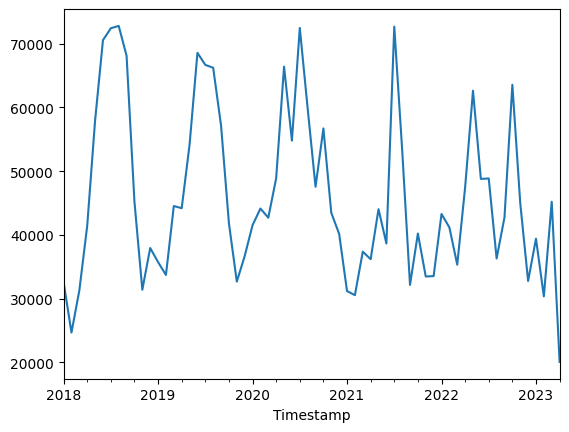

In [109]:
emissions.groupby(pd.Grouper(freq="M")).sum()['co2_percentage'].plot()

In [110]:
df_temp.set_index('Timestamp', inplace=True)
df_temp.sort_index(inplace=True)

In [111]:
df_temp.to_csv('../data/clean/clean.csv')#, index = False)

# Lagging

In [112]:
df_temp.head()

,DK_1_imports,SE_4_imports,DK_1_exports,SE_4_exports,Day_Ahead_price,Forecasted_Load,Actual_Load,Solar_[MW],ttf_price,coal_price,...,Year,Quarter,Month,Date,Day,Weekday,Hour,Week,business,Wind Total
Timestamp,,,,,,,,,,,,,,,,,,,,,
2018-01-02 00:00:00,383.0,0.0,0.0,808.0,18.12,1258.0,1245.0,0.0,19.32,102.65,...,2018,1,1,2018-01-02,2,1,0,1,True,429.0
2018-01-02 01:00:00,589.0,0.0,0.0,1019.0,14.99,1188.0,1203.0,0.0,19.32,102.65,...,2018,1,1,2018-01-02,2,1,1,1,True,375.0
2018-01-02 02:00:00,557.0,0.0,0.0,926.0,17.79,1167.0,1178.0,0.0,19.32,102.65,...,2018,1,1,2018-01-02,2,1,2,1,True,313.0
2018-01-02 03:00:00,487.0,0.0,0.0,784.0,24.51,1187.0,1180.0,0.0,19.32,102.65,...,2018,1,1,2018-01-02,2,1,3,1,True,229.0
2018-01-02 04:00:00,580.0,0.0,0.0,756.0,17.82,1235.0,1247.0,0.0,19.32,102.65,...,2018,1,1,2018-01-02,2,1,4,1,True,175.0


In [113]:
df_lag = pd.DataFrame(df_temp['Day_Ahead_price'].copy())

def lagging(df, number_of_lags):

    name = str(number_of_lags)
    df_lag['DAP-lag'+name] = df_lag['Day_Ahead_price'].shift(number_of_lags) # 1 day

In [114]:
for lag in list(np.arange(24,36)) + [24*2, 24*3, 24*7, 24*30, 24*30*3, 24*365, -24*7]:
    lagging(df_lag,lag)

In [115]:
df_lag.head(50)

,Day_Ahead_price,DAP-lag24,DAP-lag25,DAP-lag26,DAP-lag27,DAP-lag28,DAP-lag29,DAP-lag30,DAP-lag31,DAP-lag32,DAP-lag33,DAP-lag34,DAP-lag35,DAP-lag48,DAP-lag72,DAP-lag168,DAP-lag720,DAP-lag2160,DAP-lag8760,DAP-lag-168
Timestamp,,,,,,,,,,,,,,,,,,,,
2018-01-02 00:00:00,18.12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27.17
2018-01-02 01:00:00,14.99,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22.10
2018-01-02 02:00:00,17.79,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.79
2018-01-02 03:00:00,24.51,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.99
2018-01-02 04:00:00,17.82,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.24
2018-01-02 05:00:00,26.84,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14.66
2018-01-02 06:00:00,27.80,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28.99
2018-01-02 07:00:00,41.92,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,31.54
2018-01-02 08:00:00,47.95,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,32.53


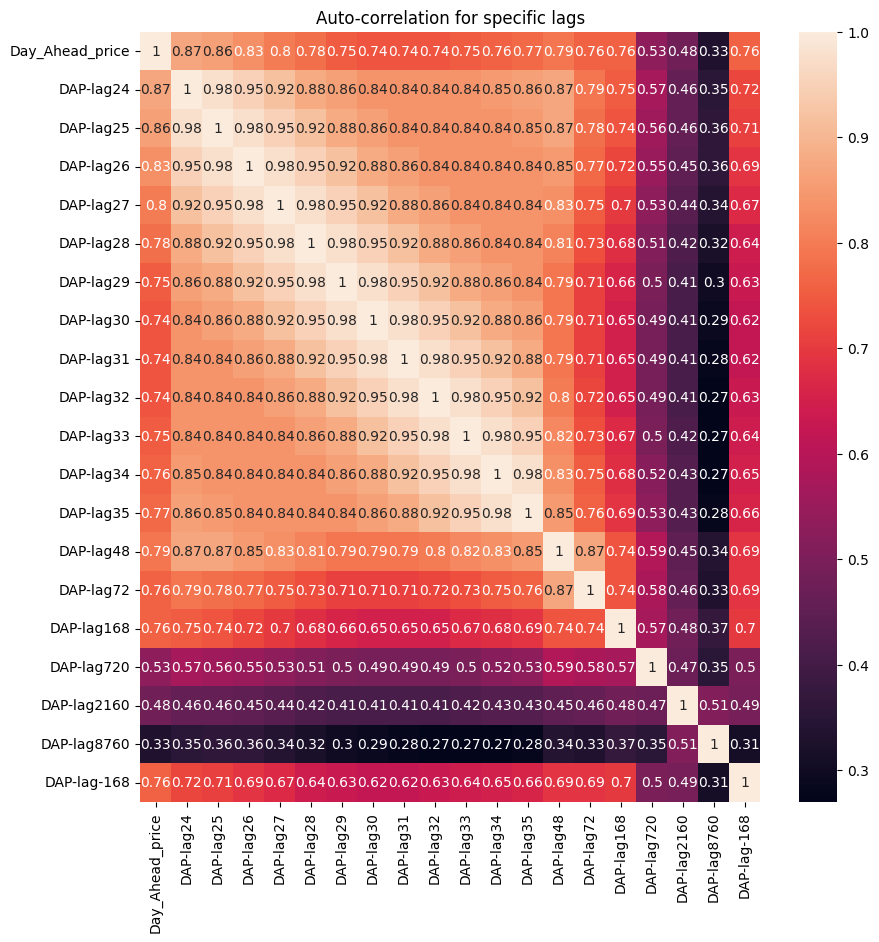

In [116]:
plt.figure(figsize = (10,10))
matrix = df_lag.corr().round(2)
sns.heatmap(matrix, annot=True)
plt.title('Auto-correlation for specific lags')
plt.show()

In [117]:
lags = [24, 36, 48, 72, 168, -168]
lags_names = ['DAP-lag'+str(lag) for lag in lags]

In [118]:
#df_lag
#df_lag = df_temp.drop(['Timestamp'], axis =  1)
for lag, name in zip(lags, lags_names):
    df_temp[name] = df_temp['Day_Ahead_price'].shift(lag)

In [119]:
matrix = df_temp.corr().round(1)

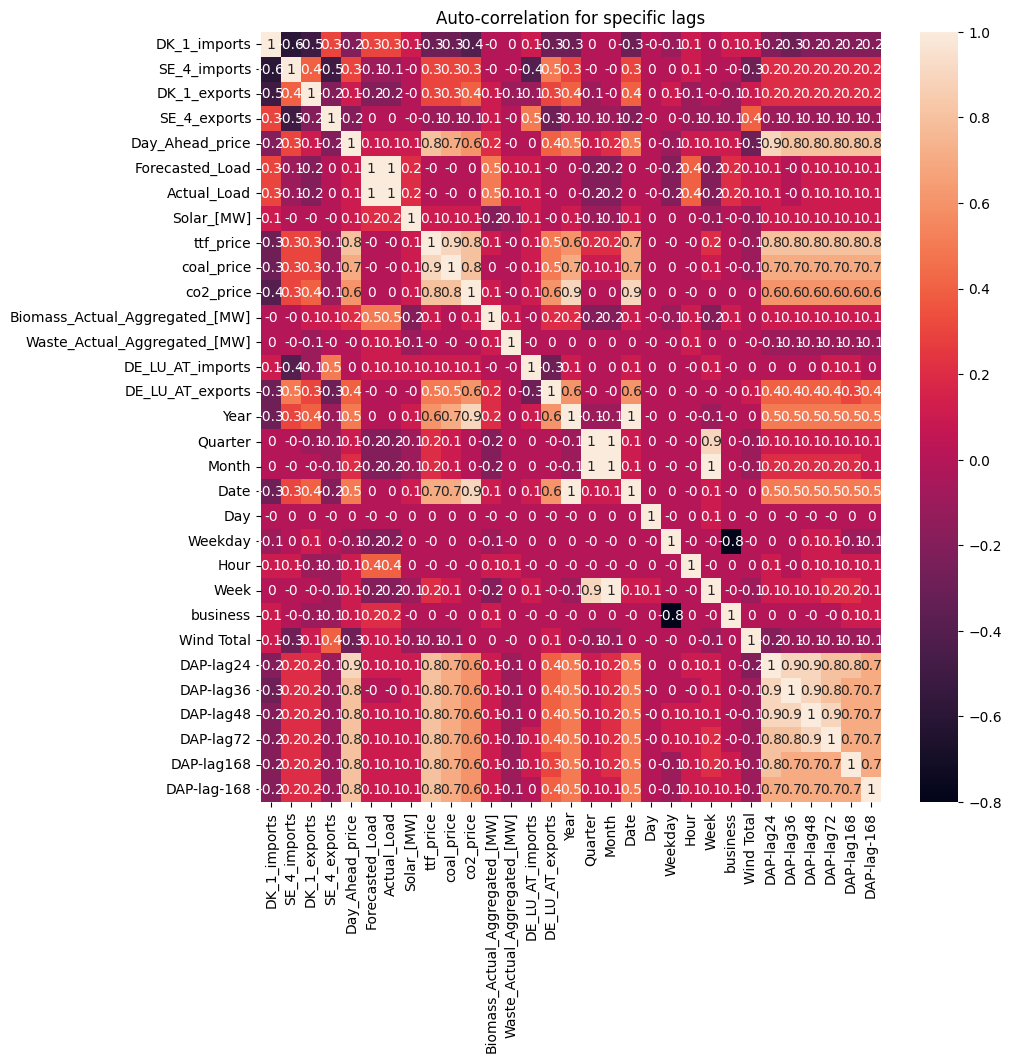

In [120]:
plt.figure(figsize = (10,10))
sns.heatmap(matrix, annot=True)
plt.title('Auto-correlation for specific lags')
plt.show()

In [121]:
df_temp.isna().sum()

DK_1_imports                        0
SE_4_imports                        0
DK_1_exports                        0
SE_4_exports                        0
Day_Ahead_price                     0
Forecasted_Load                     0
Actual_Load                         0
Solar_[MW]                          0
ttf_price                           0
coal_price                          0
co2_price                           0
Biomass_Actual_Aggregated_[MW]      0
Waste_Actual_Aggregated_[MW]        0
DE_LU_AT_imports                    0
DE_LU_AT_exports                    0
Year                                0
Quarter                             0
Month                               0
Date                                0
Day                                 0
Weekday                             0
Hour                                0
Week                                0
business                            0
Wind Total                          0
DAP-lag24                          24
DAP-lag36   

In [122]:
idx_drop = []
for col in lags_names:
    print(col, df_temp[df_temp[col].isna()]['Date'].unique())
    idx_drop=(df_temp[df_temp[col].isna()]['Date'].unique())
    df_temp.drop(df_temp[df_temp['Date'].isin(idx_drop)].index, inplace = True)

DAP-lag24 <DatetimeArray>
['2018-01-02 00:00:00']
Length: 1, dtype: datetime64[ns]
DAP-lag36 <DatetimeArray>
['2018-01-03 00:00:00']
Length: 1, dtype: datetime64[ns]
DAP-lag48 <DatetimeArray>
[]
Length: 0, dtype: datetime64[ns]
DAP-lag72 <DatetimeArray>
['2018-01-04 00:00:00']
Length: 1, dtype: datetime64[ns]
DAP-lag168 <DatetimeArray>
['2018-01-05 00:00:00', '2018-01-06 00:00:00', '2018-01-07 00:00:00',
 '2018-01-08 00:00:00']
Length: 4, dtype: datetime64[ns]
DAP-lag-168 <DatetimeArray>
['2023-04-08 00:00:00', '2023-04-09 00:00:00', '2023-04-10 00:00:00',
 '2023-04-11 00:00:00', '2023-04-12 00:00:00', '2023-04-13 00:00:00',
 '2023-04-14 00:00:00', '2023-04-15 00:00:00']
Length: 8, dtype: datetime64[ns]


In [123]:
df_temp.isna().sum()

DK_1_imports                      0
SE_4_imports                      0
DK_1_exports                      0
SE_4_exports                      0
Day_Ahead_price                   0
Forecasted_Load                   0
Actual_Load                       0
Solar_[MW]                        0
ttf_price                         0
coal_price                        0
co2_price                         0
Biomass_Actual_Aggregated_[MW]    0
Waste_Actual_Aggregated_[MW]      0
DE_LU_AT_imports                  0
DE_LU_AT_exports                  0
Year                              0
Quarter                           0
Month                             0
Date                              0
Day                               0
Weekday                           0
Hour                              0
Week                              0
business                          0
Wind Total                        0
DAP-lag24                         0
DAP-lag36                         0
DAP-lag48                   

In [124]:
df_temp.to_csv('../data/clean/clean_lagged.csv')#, index = False)